In [21]:

import numpy as np
from numpy.polynomial import Polynomial
import scipy.stats
import scipy.interpolate
import scipy.integrate
import pandas as pd
import os

from astropy.coordinates import sky_coordinate as SkyCoord, ICRS,Galactic
from astropy import units as u
import astropy.coordinates as coord
from astropy.table import Table

import time
from functools import partial
from multiprocessing import pool
import argparse

from configparser import RawConfigParser  # python 3

import matplotlib.pyplot as plt

In [3]:

def read_ini(filename):
    ini = RawConfigParser()
    ini.optionxform=str  # do not convert key to lowercase
    ini.read(filename)
    return ini

In [6]:

def getAlamAV_WC19(lam): 
    """
    Given the effective wavelenght of a photometric filter, returns the expected absoprtion in that band divided by the absorption in V.
    Calculate Eqs.(9)-(10) of Wang & Chen (2019), ApJ, 877, 116

    - lam: wavelenght in nm
    """
    if (lam < 1000): # in nm
        Y1 = 1000/lam - 1.82; # 1/um - 1.82
        as_ = np.array([0.7499, -0.1086, -0.08909, 0.02905, 0.01069, 0.001707, -0.001002])
        AlamAV = 1+np.sum(as_*np.array([Y1**(i+1) for i in range(7)]))
        return AlamAV
    else:
        return 0.3722*pow(1000/lam, 2.07)

def getHscale(b):
    """
    Nataf+13
    b in degrees
    """
    return 164/(np.abs(np.sin(np.deg2rad(b)))+1e-4) 

def getDmean(l,b):
    """
    Eqs(2)-(3) of Nataf+16
    l,b in degrees
    """
    DMrc = 14.3955 - 0.0239 * l + 0.0122*abs(b)+0.128;
    return 10**(0.2*DMrc) * 10



    
def get_pos(D,l,b,Dsun=8160,zsun=25,xyzSgrA = [-0.01362815601805778, -7.941887440118567, -6.574101760251946],_cyl=True):
    """
    Given a line of sight (l,b in degrees) and a distance, compute the Galactocentric distance in either cartessian or cylindrical coordinates

    - D: distance (any units)
    - lD: Galactic longitude (degrees)
    - bD: Galactic latitude (degrees)
    - Dsun: Galactocentric distance to the Sun (in pc)
    - zsun: height of the Sun (pc)
    - xyzSgrA (iterable): location in XYZ Galactocentric cartesian coordinates of SgrA*.

    CAREFUL! Left-handed system.
    """
    x,y,z = Dlb2xyz(D,l,b,Dsun,zsun,xyzSgrA)
    
    if _cyl:
        return np.sqrt(x**2 + y**2),z
    else:
        return x,y,z
    

In [7]:
def Dlb2xyz(D,lD,bD,Dsun = 8160,zsun=25,xyzSgrA = [-0.01362815601805778, -7.941887440118567, -6.574101760251946]):
    """
    Transform from distance and Galactic coordinates to XYZ Galactocentric cartesian coordinates.(LEFT HANDED!)

    - D: distance (any units)
    - lD: Galactic longitude (degrees)
    - bD: Galactic latitude (degrees)
    - Dsun: Galactocentric distance to the Sun (in pc)
    - zsun: height of the Sun (pc)
    - xyzSgrA (iterable): location in XYZ Galactocentric cartesian coordinates of SgrA*.
    """
    sinbsun = zsun/Dsun
    bsun = np.arcsin(sinbsun)
    cosbsun = np.cos(bsun)
    cosb = np.cos(np.deg2rad(bD))
    sinb = np.sin(np.deg2rad(bD))
    cosl = np.cos(np.deg2rad(lD))
    sinl = np.sin(np.deg2rad(lD))
    
    x = D*cosb*cosl
    y = D*cosb*sinl
    z = D*sinb
    
    x = x*cosbsun-z*sinbsun
    z = z*cosbsun + x*sinbsun
    return [Dsun*cosbsun - x - xyzSgrA[0],y - xyzSgrA[1],z - zsun - xyzSgrA[2]]

In [17]:
#load constants
cts = read_ini("../Koshimoto21_E_EX_constants.ini")

bandnames = ["J","H","Ks"]

    #dump constants into variables
components_names = cts["Basic"]["components"].split(cts["Basic"]["separator"])
print(components_names)
def_mag_err = cts["data"]["default_photerror"]
if def_mag_err == "none":
    def_mag_err = None
else:
    def_mag_err = float(def_mag_err)
min_mag_error = cts["Basic"].getfloat("mag_error_threshold",fallback=0.05)
    
photsys = cts["Basic"]["photsys"]
lamJ = cts[photsys].getfloat("J",fallback="This band does not exist")
lamH = cts[photsys].getfloat("H",fallback="This band does not exist")
lamKs = cts[photsys].getfloat("Ks",fallback="This band does not exist")

Mu = cts["IMF"].getfloat("Mass_max") #max mass
Ml = cts["IMF"].getfloat("Mass_min") #min mass
nM = cts["IMF"].getint("num_bins_M")
IMF_params = {"Mu":Mu,"Ml":Ml,"M1":cts["IMF"].getfloat("M1"),"M2":cts["IMF"].getfloat("M2"),
                 "alpha1":cts["IMF"].getfloat("alpha1"),"alpha2":cts["IMF"].getfloat("alpha2"),"alpha3":cts["IMF"].getfloat("alpha3"),"norm":cts["IMF"].getfloat("norm")}

Dmax = cts["Basic"].getfloat("Dmax") #max distance in pc
Dmin = cts["Basic"].getfloat("Dmin") #min distance in pc
nD = cts["Basic"].getint("num_bins_D")
icomps = len(components_names)

sig_lim = cts["Basic"].getfloat("sigma_threshold")
sig_cut = cts["Basic"].getint("counts_lim")

n0MS = [cts[name].getfloat("n0MS",fallback=0.0) for name in components_names]

if "bar" in components_names:
    bar_angle = cts["bar"].getfloat("bar_angle")
else:
    bar_angle = None

costheta = np.cos(np.deg2rad(bar_angle))
sintheta = np.sin(np.deg2rad(bar_angle))


    #prepare other constants
EJKAV = getAlamAV_WC19(1254.0) - getAlamAV_WC19(2149.0); # 1254.0 = lamJ,VVV, 2149.0 = lamK,VVV 
EJK2AJ = getAlamAV_WC19(lamJ)/EJKAV
EJK2AH = getAlamAV_WC19(lamH)/EJKAV
EJK2AKs = getAlamAV_WC19(lamKs)/EJKAV

['thin1', 'thin2', 'thin3', 'thin4', 'thin5', 'thin6', 'thin7', 'thick', 'bar', 'nsd', 'nsc']


In [18]:
MLdirectory = "../input_files/"

#Load files and create interpolators
EXTMAPfile = cts["Basic"]["EXTMAPfile"]
rot_curve_file = cts["Basic"]["ROTCURVEfile"]
    #load rotation curve and create interpolator
rot_curve_data = np.loadtxt(MLdirectory+rot_curve_file,delimiter=",",comments="#")
#rot_curve_data[:,0] in kiloparsecs! NEED TO CONVERT TO PARSECS 
rotation_curve_intp = scipy.interpolate.interp1d(rot_curve_data[:,0]*1000,rot_curve_data[:,1],kind="linear",bounds_error=False,)
    #load ML and create interpolators


mass_index = cts[photsys].getint("ML_mass_offset")
ML_mag_offset = cts[photsys].getint("ML_mag_offset")
ML_sig_offset = cts[photsys].getint("ML_sigma_offset")
ML_max_offset = cts[photsys].getint("ML_max_offset")
ML = [np.loadtxt(MLdirectory+file) for component,file in dict(cts[cts["Basic"]["photsys"]]).items() if component.endswith("file")]
interpolators = []
for icomp,ML_i in enumerate(ML):
    log10mass = np.log10(ML_i[:,mass_index])
        #absolute magnitudes corresponding to each mass: Mass-Luminosity relation
    mag_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_mag_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #dispersion in magnitudes at each mass bin resulting from age and metallicity dispersion
    sigma_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_sig_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
        #faintest magnitude attainable at each mass bin
    max_interpol = [scipy.interpolate.interp1d(log10mass,ML_i[:,i+ML_max_offset],kind="linear",bounds_error=False,) for i,band in enumerate(bandnames)]
    interpolators.append(mag_interpol+sigma_interpol+max_interpol)

In [73]:
#load EXTMAP
extmap = np.loadtxt(MLdirectory+EXTMAPfile,delimiter=cts["Basic"]["EXTMAPdelimiter"])

# Plot interpolators and compare to their HR diagrams

In [58]:
logmass_bins = np.linspace(0,1,20000)

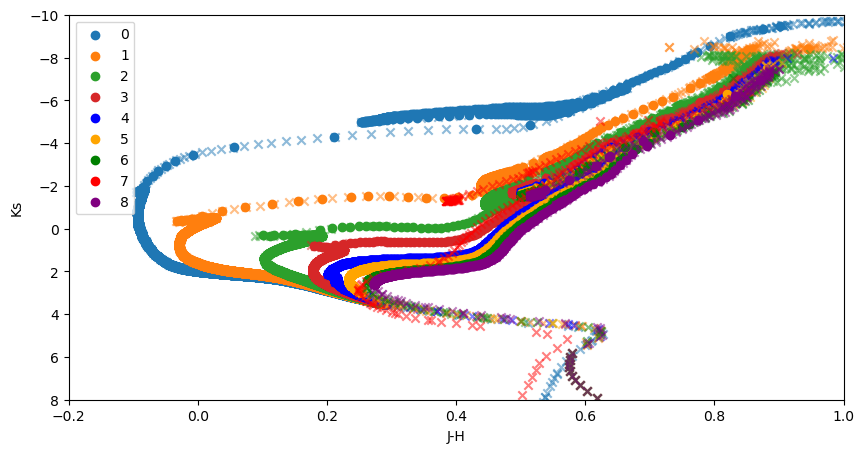

In [60]:
fig,axes = plt.subplots(figsize=(10,5))

colors = ["tab:blue","tab:orange","tab:green","tab:red","blue","orange","green","red","purple"]

for i in range(9):
    Jmag = interpolators[i][0](logmass_bins)
    Hmag = interpolators[i][1](logmass_bins)
    Ksmag = interpolators[i][2](logmass_bins)
    
    cc = axes.scatter(Jmag-Hmag,Ksmag,label="{}".format(i),c=colors[i],marker="o",rasterized=True)
    axes.scatter(ML[i][:,0+ML_mag_offset]-ML[i][:,1+ML_mag_offset],ML[i][:,2+ML_mag_offset],c=colors[i],marker="x",alpha=0.5)

axes.set_xlabel("J-H")
axes.set_ylabel("Ks")
axes.set_ylim(8,-10)
axes.set_xlim(-0.2,1)
axes.legend();

# Measure distance from observation to each of the HR diagrams

In [61]:
def get_gaussian_distance(mags_notnan,mag_errors_notnan,dist_bins,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    return np.stack([get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan) for D in dist_bins])

def get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    """
    If the magnitude of a band is fainter than the max magnitude, it is heavily penalised (+99 sigmas)
    """
    prob = np.sum([(mag_ - (MLi[:,ML_indices[i]] + A0s_notnan[i]*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))))**2/\
                   (mag_errors_notnan[i]**2 + MLi[:,sigma_indices[i]]**2) + \
        99*np.heaviside(mag_ - (MLi[:,max_indices[i]] + A0s_notnan[i]*EJKs*(1 - np.exp(-D/hscale)) + 5 * np.log10(0.1*(D + 0.1))),1) \
                   for i,mag_ in enumerate(mags_notnan)],axis=0)
    return prob
    
def gaussian_cdf(x,mu,sigma):
    return 0.5*(1+scipy.special.erf((x-mu)/sigma/np.sqrt(2)))

def gaussian_truncated_pdf(x,mu,sigma,x_max):
    return 1/gaussian_cdf(x_max,mu,sigma)*np.heaviside(x_max - x,1)/np.sqrt(2*np.pi)/sigma*np.exp(-1/2*((x - mu)/sigma)**2)

def get_likelihood(mags_notnan,mag_errors_notnan,mass,D,interpolator,interpol_indices,hscale,EJKs,A0s_notnan):
    """
    Product of N truncated gaussian distributions, each one normalised to area 1.

    Interpolator is a list object with 9 interpolators inside, all function of log10(mass):
    - three (0-2) for photometry: J, H and Ks
    - three (3-5) for the dispersion in these three bands (result of age and metallicity dispersions)
    - three (6-8) for the faintest magnitude achivable with that mass. 

    The faintest magnitude truncates the gaussian.
    """
        #escale absorption by the distance
    DM = 5 * np.log10(0.1*(D + 0.1))
    Dist_scale = (1 - np.exp(-D/hscale))
    log10mass = np.log10(mass)
    return np.nan_to_num(np.prod([gaussian_truncated_pdf(mag_,interpolator[interpol_indices[i]](log10mass) + A0s_notnan[i]*EJKs*Dist_scale + DM,np.sqrt((mag_errors_notnan[i]**2 + (interpolator[interpol_indices[i]+len(bandnames)](log10mass))**2)),interpolator[interpol_indices[i]+2*len(bandnames)](log10mass) + A0s_notnan[i]*EJKs*Dist_scale + DM) for i,mag_ in enumerate(mags_notnan)],axis=0))

In [ ]:
def get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan):
    return np.stack([get_gaussian_distance_atD(mags_notnan,mag_errors_notnan,D,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan) for D in dist_bins])


In [78]:
l = 0
b = 0

mags_notnan = np.array([16,15,14])
mag_errors_notnan = np.array([0.1,0.1,0.1])
D = 1000 #pc

interpol_indices = np.array([0,1,2])
ML_indices    = interpol_indices + ML_mag_offset
sigma_indices = interpol_indices + ML_sig_offset
max_indices   = interpol_indices + ML_max_offset

hscale = getHscale(b)
Dmean = getDmean(l,b)
EJKs =  extmap[np.argmin(np.sqrt((extmap[:,0]-l)**2+(extmap[:,1]-b)**2))][-1]
A0J = EJK2AJ/(1 - np.exp(-Dmean/hscale))
A0H = EJK2AH/(1 - np.exp(-Dmean/hscale))
A0Ks = EJK2AKs/(1 - np.exp(-Dmean/hscale))
A0s_notnan = [A0J,A0H,A0Ks]

In [119]:
dist_bins = np.logspace(np.log10(Dmin),np.log10(12000),10000+1)

In [178]:
selected_particles = []
for icomp_,MLi in enumerate(ML):
    #To-Do: check if it works with only one magnitude
    dist_std = get_gaussian_distance(mags_notnan,mag_errors_notnan,dist_bins,MLi,ML_indices,sigma_indices,max_indices,hscale,EJKs,A0s_notnan)
    
    #B) Find points where distance is smaller than N-sigmas
    close_HRd_mask = dist_std<sig_lim
    close_HRd_mask_m = np.sum(close_HRd_mask,axis=1)
    #C) Compute the likelihood
    ## C.1) If there are NO points within N-sigma, simply ignore it
    ## C.2) If there is only 1 point within N-sigma, then just integrate within 90% and 110% of the closest mass
    ## C.3) Otherwise, numerically integrate within mass range (smallest and largest mass that are within 6sigma of observable)
    mask = close_HRd_mask_m>sig_cut

    selected_particles.append(MLi[mask])

IndexError: boolean index did not match indexed array along axis 0; size of axis is 468 but size of corresponding boolean axis is 10001

In [150]:
MLi.shape

(468, 18)

In [152]:
mask.shape

(10001,)

In [176]:
close_HRd_mask.shape

(10001, 468)

In [182]:
close_HRd_mask_m[3955]

np.int64(0)

In [183]:
np.where(close_HRd_mask_m>0)

(array([ 3988,  3989,  3990, ...,  9998,  9999, 10000]),)

In [157]:
dist_bins[mask]

array([  169.0353281 ,   169.15521794,   169.27519282, ...,
       11982.9958745 , 11991.49492324, 12000.        ])

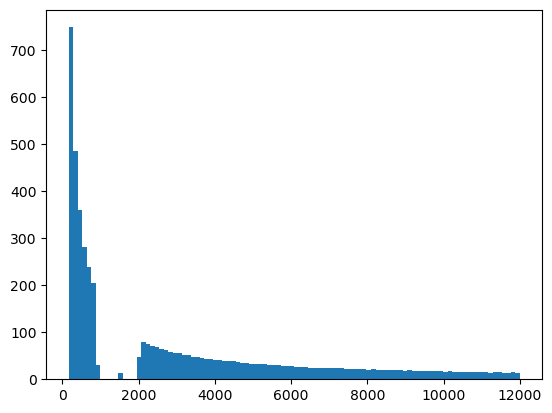

In [156]:
plt.hist(dist_bins[mask],bins=100);

In [173]:
dist_bins[3955]

np.float64(165.1262745554218)

In [187]:
np.min(dist_std[j,:])

np.float64(1.9551555113671695)

/var/folders/vj/7jqz0m1j2zs3t7fxnl0d1gfw0000gn/T/ipykernel_89060/2444911781.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  cc = axes.scatter((Jmag-Hmag)[dist_std[j,:]<2],Ksmag[dist_std[j,:]<2],c="k",marker="o",alpha=1,vmin=0,vmax=10)


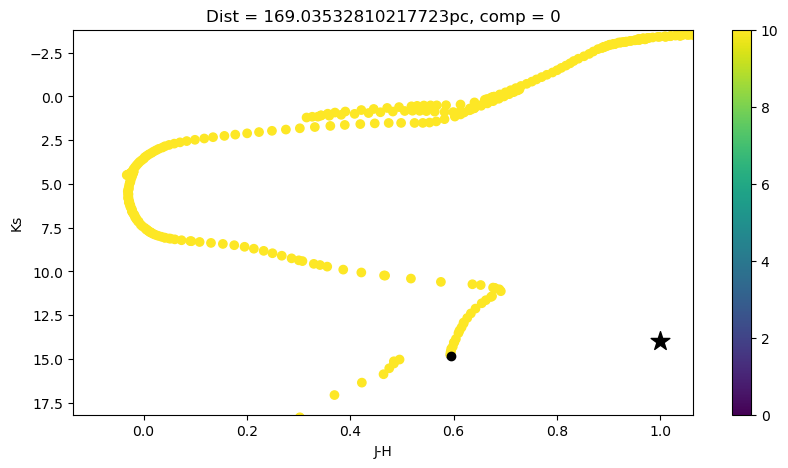

In [191]:
fig,axes = plt.subplots(figsize=(10,5))

j = 3988
D = dist_bins[j]
DM = 5 * np.log10(0.1*(D + 0.1))
Dist_scale = (1 - np.exp(-D/hscale))

i = 0
Jmag = ML[i][:,0+ML_mag_offset] + A0s_notnan[0]*EJKs*Dist_scale + DM
Hmag = ML[i][:,1+ML_mag_offset] + A0s_notnan[1]*EJKs*Dist_scale + DM
Ksmag = ML[i][:,2+ML_mag_offset] + A0s_notnan[2]*EJKs*Dist_scale + DM

axes.scatter(mags_notnan[0]-mags_notnan[1],mags_notnan[2],marker="*",s=200,c="k")

cc = axes.scatter(Jmag-Hmag,Ksmag,c=dist_std[j,:],marker="o",alpha=1,vmin=0,vmax=10)
plt.colorbar(cc)

cc = axes.scatter((Jmag-Hmag)[dist_std[j,:]<2],Ksmag[dist_std[j,:]<2],c="k",marker="o",alpha=1,vmin=0,vmax=10)

# axes.errorbar(Jmag-Hmag,Ksmag,xerr=np.sqrt(MLi[:,sigma_indices[0]]**2+MLi[:,sigma_indices[1]]**2),
#                    yerr=MLi[:,sigma_indices[2]],alpha=0.3)
# axes.errorbar(Jmag-Hmag,Ksmag,xerr=MLi[:,sigma_indices[0]],
#                    yerr=MLi[:,sigma_indices[2]],alpha=0.3)

plt.title("Dist = {}pc, comp = {}".format(D,i))
axes.set_xlabel("J-H")
axes.set_ylabel("Ks")
axes.set_ylim(12+ A0s_notnan[2]*EJKs*Dist_scale + DM,-10+ A0s_notnan[2]*EJKs*Dist_scale + DM)
axes.set_xlim(-0.2+(A0s_notnan[0]-A0s_notnan[1])*EJKs*Dist_scale,1+(A0s_notnan[0]-A0s_notnan[1])*EJKs*Dist_scale);

i = 0 => D 2800pc

In [192]:
ML[i][dist_std[j,:]<2]

array([[ 0.09  ,  0.09  ,  0.22  , 16.263 , 12.081 ,  9.512 ,  8.981 ,
         8.617 ,  9.388 ,  0.5795,  0.5883,  0.6033,  7.585 ,  7.032 ,
         6.809 ,  9.721 ,  9.2232,  9.0187]])

In [193]:
mags_notnan

array([16, 15, 14])

In [194]:
Jmag[dist_std[j,:]<2]

array([15.79241298])

In [195]:
Hmag[dist_std[j,:]<2]

array([15.19791834])

In [196]:
Ksmag[dist_std[j,:]<2]

array([14.80214287])

Because we are treating each magnitude band (at a fixed mass) as three independent things, we can get incoherent colours!

In [218]:
headers = {0:"#Mini MPD Rad MV_j MI_c MJ_2M MH_2M MK_2M MHw sigmaJ sigmaH sigmaKs minJ minH minKs maxJ maxH maxKs counts\n",
            1:"#Mini MPD Rad MJ_2M MH_2M MK_2M MZ087 MW146 MF213 MHw sigmaJ sigmaH sigmaKs minJ minH minKs maxJ maxH maxKs counts\n"}

In [209]:
headers[0][45:]

' sigmaJ sigmaH sigmaKs minJ minH minKs maxJ maxH maxKs counts\n'

In [210]:
headers[1][53:]

' sigmaJ sigmaH sigmaKs minJ minH minKs maxJ maxH maxKs counts\n'

In [211]:
headers = {0:"#Mini MPD Rad MV_j MI_c MJ_2M MH_2M MK_2M MHw meanJH meanJKs meanHKs sigmaJH sigmaJKs sigmaHKs maxJH maxJKs maxHKs minJH minJKs minHKs counts\n",
           1:"#Mini MPD Rad MJ_2M MH_2M MK_2M MZ087 MW146 MF213 MHw meanJH meanJKs meanHKs sigmaJH sigmaJKs sigmaHKs maxJH maxJKs maxHKs minJH minJKs minHKs counts\n"}

In [212]:
headers[0][45:]

' meanJH meanJKs meanHKs sigmaJH sigmaJKs sigmaHKs maxJH maxJKs maxHKs minJH minJKs minHKs counts\n'

In [213]:
headers[1][53:]

' meanJH meanJKs meanHKs sigmaJH sigmaJKs sigmaHKs maxJH maxJKs maxHKs minJH minJKs minHKs counts\n'

In [214]:
start_of_new_header = {0:45,1:53}

In [220]:
headers[0][start_of_new_header[0]:]

' sigmaJ sigmaH sigmaKs minJ minH minKs maxJ maxH maxKs counts\n'